In [2]:
# Import necessary libraries
import boto3
import joblib
import sagemaker
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('thyroid.csv')

# Display first 5 rows of dataset
data.head()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/27/25 00:31:58] INFO     Found credentials from IAM Role:                                   ]8;id=553195;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=998427;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,29,F,f,f.1,f.2,f.3,f.4,f.5,f.6,t,...,f.14,?.1,f.15,?.2,f.16,?.3,f.17,?.4,other,-[840801013]
0,29,F,f,f,f,f,f,f,f,f,...,t,128,f,?,f,?,f,?,other,-[840801014]
1,41,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,11,other,-[840801042]
2,36,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803046]
3,32,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,36,other,S[840803047]
4,60,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803048]


### Step 1: Importing and Previewing the Dataset

We begin by importing the required library, **Pandas**, to handle data manipulation and loading.

The dataset `thyroid.csv` is then read into a Pandas DataFrame. To understand the structure and contents of the data, we display the first 5 rows using `data.head()`.

From this preview, we observe:
- The dataset contains **30 columns**, including a mix of numerical and categorical values.
- Many columns use `'?'` to represent missing data.
- The dataset appears to contain anonymized or encoded patient records, including flags such as `'f'` and `'t'` for binary conditions.

This step helps us inspect column names and identify preprocessing tasks such as cleaning, encoding, and handling missing values.


In [3]:
# Drop the 'other' column if it exists
if 'other' in data.columns:
    data.drop('other', axis=1, inplace=True)
    print("'other' column dropped successfully.")
else:
    print("'other' column not found.")

# Verify columns again
data.head()


'other' column dropped successfully.


,29,F,f,f.1,f.2,f.3,f.4,f.5,f.6,t,...,?,f.14,?.1,f.15,?.2,f.16,?.3,f.17,?.4,-[840801013]
0,29,F,f,f,f,f,f,f,f,f,...,1.9,t,128,f,?,f,?,f,?,-[840801014]
1,41,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,11,-[840801042]
2,36,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,26,-[840803046]
3,32,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,36,S[840803047]
4,60,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,26,-[840803048]


To streamline the dataset, we first check for and remove any non-informative or irrelevant columns. In this case, we identified a column named `'other'`, which does not contribute meaningfully to the prediction task.

The conditional `if 'other' in data.columns:` ensures the column is only dropped if it exists, avoiding errors. After dropping, we use `data.head()` again to confirm the update.

As a result, the dataset now contains 29 columns.


In [4]:
# List of column names as provided
fcols = ["age",
         "sex",
         "on_thyroxine",
         "query_on_thyroxine",
         "on_antithyroid_medication",
         "sick",
         "pregnant",
         "thyroid_surgery",
         "I131_treatment",
         "query_hypothyroid",
         "query_hyperthyroid",
         "lithium",
         "goitre",
         "tumor",
         "hypopituitary",
         "psych",
         "TSH_measured",
         "TSH",
         "T3_measured",
         "T3",
         "TT4_measured",
         "TT4",
         "T4U_measured",
         "T4U",
         "FTI_measured",
         "FTI",
         "TBG_measured",
         "TBG",
         "target"]

# Assigning names to columns
data.columns = fcols

# Check first few rows again to confirm
data.head()


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,target
0,29,F,f,f,f,f,f,f,f,f,...,1.9,t,128,f,?,f,?,f,?,-[840801014]
1,41,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,11,-[840801042]
2,36,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,26,-[840803046]
3,32,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,36,S[840803047]
4,60,F,f,f,f,f,f,f,f,f,...,?,f,?,f,?,f,?,t,26,-[840803048]


The dataset originally had generic or unnamed column headers. To enhance readability and facilitate downstream processing, we assign meaningful column names based on the dataset’s documentation.

The `fcols` list contains the cleaned and descriptive names corresponding to patient attributes, medical history, and thyroid-related test results. These names are then applied to the dataset using:

```python
data.columns = fcols


In [5]:
# Extracting the actual target label from the 'target' column
target = data.target

# Splitting the target column to isolate the disease type clearly
create = target.str.split('([A-Za-z]+)', expand=True)
create = create[1]  # we select the disease type from split results

# Replacing missing values clearly with 0
target = create.replace({None:'Z'}) # 'Z' indicates no diagnosis

# Reassign the clean target back to dataset
data['target'] = target

# Verify the target column clearly
data['target'].value_counts()


Z      6770
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        85
GK       49
AK       46
J        30
B        21
C        18
MK       16
O        14
Q        14
KJ       11
GI       10
D         9
H         8
FK        6
P         5
MI        2
LJ        1
GKJ       1
OI        1
E         1
Name: target, dtype: int64

The `target` column contains encoded information about thyroid disease diagnoses, represented as combinations of letters. To make this column usable for classification tasks, we extract the actual disease label by splitting on alphabetic characters.

- We use a regular expression `([A-Za-z]+)` to extract meaningful disease indicators from each entry.
- The second element from the split (`create[1]`) is used as the cleaned label.
- Missing values (typically represented as `None`) are replaced with `'Z'`, which is interpreted as "no diagnosis".

We then reassign this cleaned label back to the original DataFrame. Finally, we use `value_counts()` to verify the distribution of disease classes. As shown, the majority of patients (6770) have the label `'Z'`, indicating no diagnosis, while the remaining entries span various thyroid-related conditions (e.g., K, G, I, F, R).


[04/27/25 00:32:05] INFO     Using categorical units to plot a list of strings that are all         ]8;id=812617;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=585927;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

[04/27/25 00:32:06] INFO     Using categorical units to plot a list of strings that are all         ]8;id=743051;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=725626;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

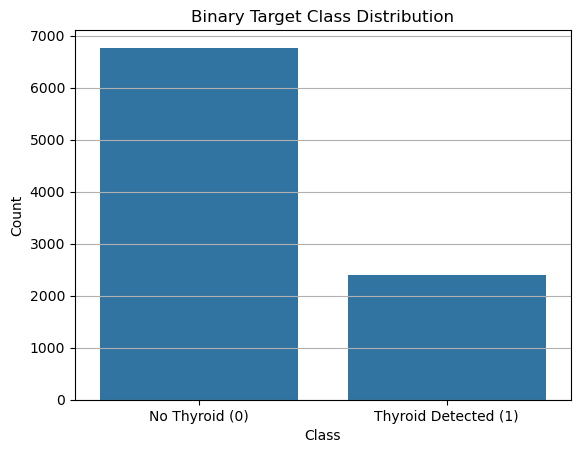

In [6]:

# Creating binary classification (0 = no thyroid condition 'Z', 1 = thyroid condition present)
data['binary_target'] = data['target'].apply(lambda x: 0 if x == 'Z' else 1)

# Check distribution clearly
sns.countplot(x='binary_target', data=data)
plt.xticks(ticks=[0, 1], labels=['No Thyroid (0)', 'Thyroid Detected (1)'])
plt.title("Binary Target Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


To simplify the classification task, we convert the multi-class target column into a binary target. The logic used is:

- `0` indicates **no thyroid condition** (original label `'Z'`)
- `1` indicates **presence of a thyroid condition** (any label other than `'Z'`)

This transformation is implemented using a lambda function and stored in a new column called `'binary_target'`.

To understand the class distribution, we visualize the counts using a bar plot:
- The plot reveals class imbalance, with a significantly higher number of patients without thyroid issues (`0`) compared to those with the condition (`1`).
- This insight will be important later while handling model evaluation and potential resampling strategies.


In [7]:

# Standardize missing values
# Replace all '?' entries with np.nan for consistent missing value handling
data.replace('?', np.nan, inplace=True)
print(" Replaced '?' with np.nan for standardization.\n")

# Display missing value counts before cleaning
missing_values = data.isnull().sum().sort_values(ascending=False)
print("Missing values before cleaning:\n")
print(missing_values)

# Drop columns with excessive missing values (e.g., > 90%)
columns_to_drop = ['TBG', 'TBG_measured']
for col in columns_to_drop:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)
        print(f" Dropped column '{col}' due to high missing rate.\n")

# Convert numeric columns to proper float types
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Ensure invalid values become NaN

# Impute missing numeric values with median (robust to outliers)
for col in numeric_columns:
    median = data[col].median()
    data[col].fillna(median, inplace=True)
    print(f" Filled missing values in '{col}' with median: {median}")

# Impute missing categorical values with mode
categorical_columns = data.select_dtypes(include='object').columns
for col in categorical_columns:
    mode = data[col].mode()[0]
    data[col].fillna(mode, inplace=True)
    print(f" Filled missing values in '{col}' with mode: {mode}")

# Confirm that all missing values are handled
print("\n After cleaning, missing values per column:\n")
print(data.isnull().sum())


 Replaced '?' with np.nan for standardization.

Missing values before cleaning:

TBG                          8822
T3                           2603
TSH                           842
T4U                           808
FTI                           801
TT4                           441
sex                           307
thyroid_surgery                 0
pregnant                        0
age                             0
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
tumor                           0
goitre                          0
lithium                         0
query_hyperthyroid              0
query_hypothyroid               0
I131_treatment                  0
TSH_measured                    0
hypopituitary                   0
TT4_measured                    0
T3_measured                     0
psych                           0
T4U_measured                    0
FTI_measured                    0
T

### 🧹 Handling Missing Values

To ensure our model trains on clean and consistent data, we performed a comprehensive missing value treatment process:

- **Step 1:** Replaced all `'?'` placeholders with `NaN` for standardized handling using `np.nan`.
- **Step 2:** Displayed the count of missing values per column to understand data sparsity.
- **Step 3:** Dropped columns with excessive missing values (`'TBG'`, `'TBG_measured'`) as they provided limited utility for prediction.
- **Step 4:**
  - For **numeric columns** (`'age'`, `'TSH'`, `'T3'`, `'TT4'`, `'T4U'`, `'FTI'`), we:
    - Coerced them to numeric types for consistency.
    - Imputed missing values using the **median**, which is robust to outliers.
  - For **categorical columns**, we:
    - Imputed missing values using the **mode** (most frequent value).
- **Step 5:** Verified that no missing values remained in the dataset post-cleaning.

> This preprocessing ensures the dataset is clean and reliable for model training, and prevents any issues during evaluation due to incomplete data.


In [8]:
# Display transposed statistical summary of numeric columns
summary_stats = data.describe().T.round(2)

# Show summary
print(" Summary Statistics of Numeric Features:\n")
summary_stats


 Summary Statistics of Numeric Features:



,count,mean,std,min,25%,50%,75%,max
age,9171.0,73.56,1184.04,1.00,37.00,55.00,68.00,65526.00
TSH,9171.0,4.87,23.07,0.00,0.59,1.40,2.50,530.00
T3,9171.0,1.95,0.75,0.05,1.70,1.90,2.20,18.00
TT4,9171.0,108.47,36.62,2.00,88.00,104.00,124.00,600.00
T4U,9171.0,0.97,0.19,0.17,0.87,0.96,1.05,2.33
FTI,9171.0,113.24,39.72,1.40,95.00,109.00,126.00,881.00
binary_target,9171.0,0.26,0.44,0.00,0.00,0.00,1.00,1.00


### 📊 Statistical Summary

We used the `.describe().T` function to generate a **statistical overview** of the dataset’s numeric features. This includes key metrics such as:

- **Count:** Number of non-missing observations per feature
- **Mean & Std:** Measures of central tendency and spread
- **Min/Max:** Range of values in the dataset
- **25%, 50%, 75% Quartiles:** Indicate data distribution and skewness

#### Key Observations:
- **Age** ranges from 1 to 6526, suggesting the presence of outliers or data entry issues.
- **TSH and T3** values show a wide spread with high standard deviations relative to their means.
- **TT4 and FTI** have significantly higher max values, further indicating possible outliers.
- The **binary_target** has a mean of ~0.26, aligning with the earlier class imbalance visualization where most patients do **not** have thyroid conditions.

> This summary aids in understanding variable scales, spotting anomalies, and preparing for scaling/normalization if needed during model training.


In [9]:
# Checkgin for extreme age values
print("Age range before filtering:", data['age'].min(), "to", data['age'].max())

# Capping age values at a maximum threshold (100)
data['age'] = data['age'].apply(lambda x: min(x, 100))

# Confirming result
print("Age range after outlier handling:", data['age'].min(), "to", data['age'].max())


Age range before filtering: 1 to 65526
Age range after outlier handling: 1 to 100


###  Outlier Handling – Age

The statistical summary revealed an extreme age value exceeding 65,000, which is not realistic for clinical data. To address this:

- We capped the `'age'` column to a maximum of **100 years**, assuming anything beyond that to be erroneous or non-representative.
- Alternatively, rows with `age > 100` could be dropped if necessary.

This step ensures more reliable correlation and model training outcomes without distortion from extreme values.


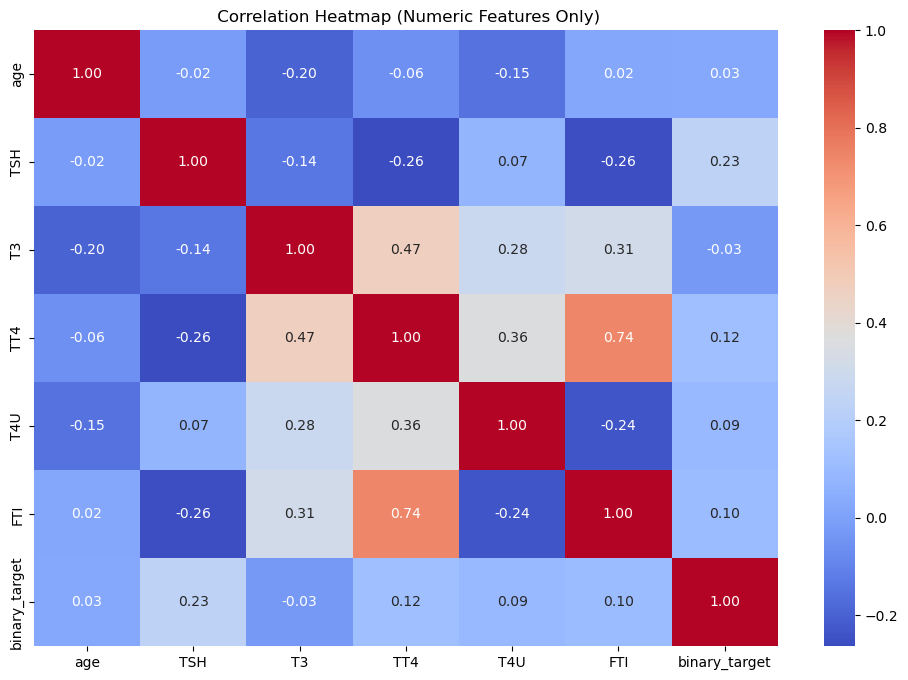

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title(" Correlation Heatmap (Numeric Features Only)")
plt.show()


### Correlation Heatmap (Numeric Features)

To evaluate relationships between numerical variables, we plotted a **correlation heatmap** using `seaborn`.

- Only numeric columns are included using `numeric_only=True` to avoid warnings and irrelevant pairings.
- Strong correlations are marked in red (positive) and blue (negative).

#### Key Insights:
- `FTI` and `TT4` are strongly correlated (0.74), indicating potential redundancy.
- `TSH` has a mild negative correlation with `TT4` and `FTI`, which aligns with known clinical patterns.
- Most features show low correlation with `binary_target`, suggesting multivariate modeling is required.

This analysis helps in detecting multicollinearity and informs decisions about feature reduction or transformation.


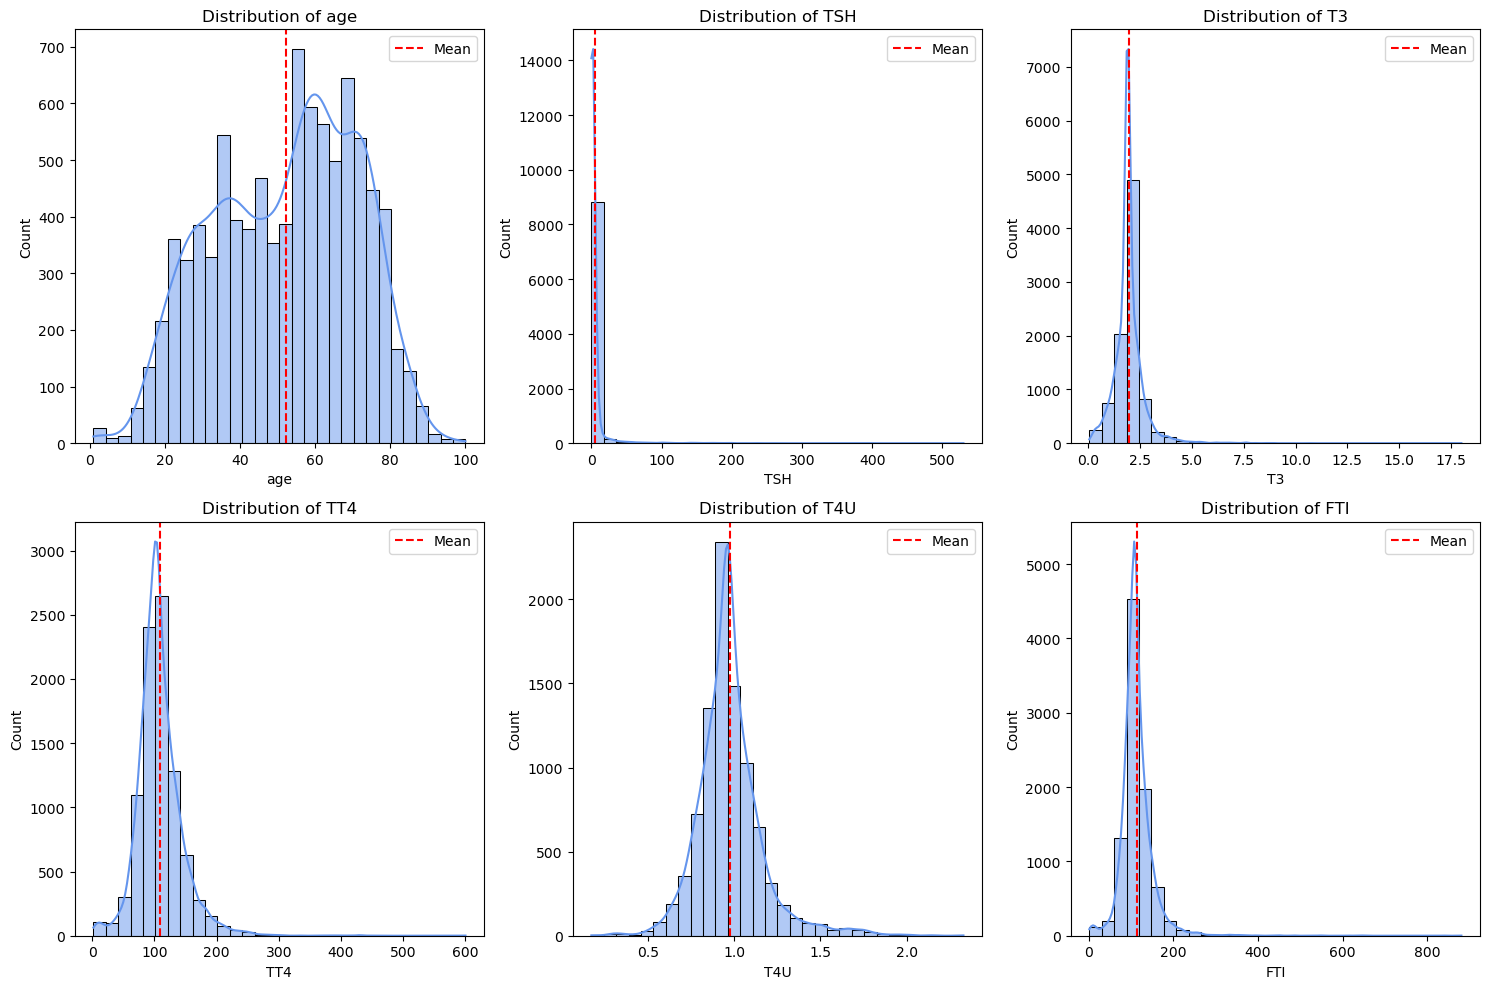

In [11]:
# Histogram plots of numeric features to understand distribution
numeric_features = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[feature], bins=30, kde=True, color='cornflowerblue')
    plt.axvline(data[feature].mean(), color='red', linestyle='--', label='Mean')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend()
plt.tight_layout()
plt.show()


### Distribution of Numeric Features

We plotted the distributions of key numeric features (`age`, `TSH`, `T3`, `TT4`, `T4U`, and `FTI`) using histograms and kernel density estimates (KDE).

#### Observations:
- **Age**: Right-skewed, with most patients under 100 years old.
- **TSH**: Highly skewed with long tail on the right — may benefit from log scaling.
- **T3** and **TT4**: Somewhat bell-shaped, but still skewed.
- **T4U**: Appears close to normal distribution.
- **FTI**: Wide spread with several high-end values — possible outliers.

> Vertical red lines indicate the **mean** for each feature.  
These visualizations help us detect skewness, consider transformations, and understand the data's underlying distribution prior to modeling.


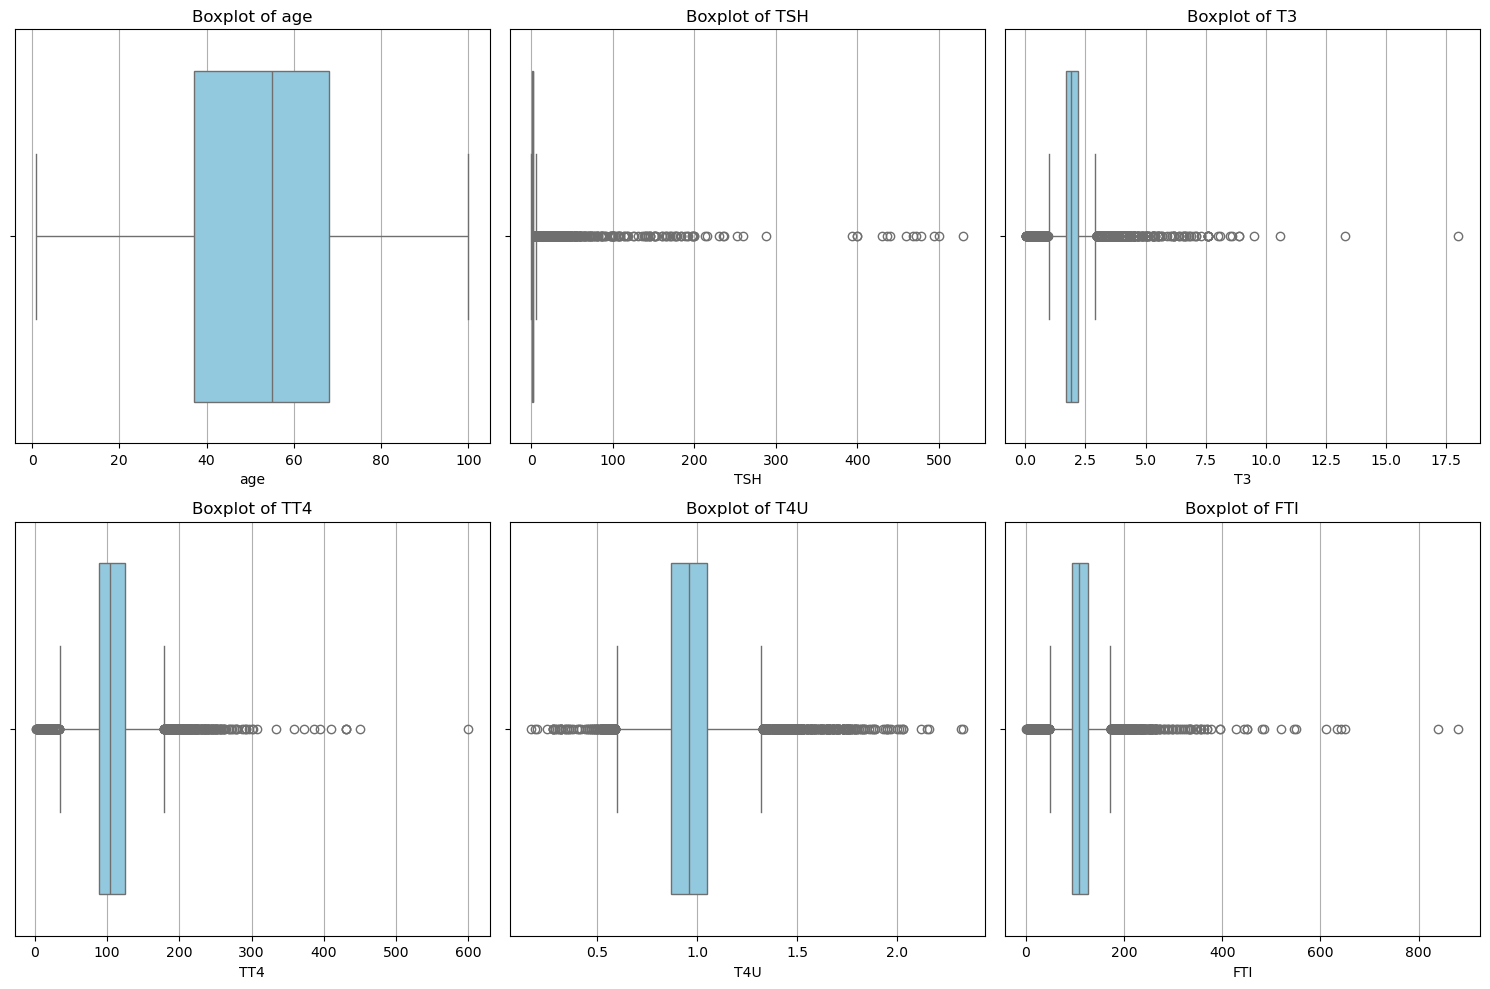

In [12]:
# Boxplots for numeric features to detect potential outliers
numeric_features = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=data[feature], color='skyblue')
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Boxplot Analysis of Numeric Features

Boxplots were generated to detect **outliers** and examine the spread of numeric features:

#### Key Observations:
- **Age**: Outliers were previously removed, and the boxplot now shows a more reasonable range.
- **TSH**: Displays extreme right-side outliers — expected due to its skewed clinical distribution.
- **T3**, **TT4**, and **FTI**: Contain a moderate number of outliers, with wider interquartile ranges.
- **T4U**: Distribution appears more centered and symmetric.

> These outlier patterns help guide future decisions on **normalization**, **log transformations**, or **robust models** that are less sensitive to extreme values.


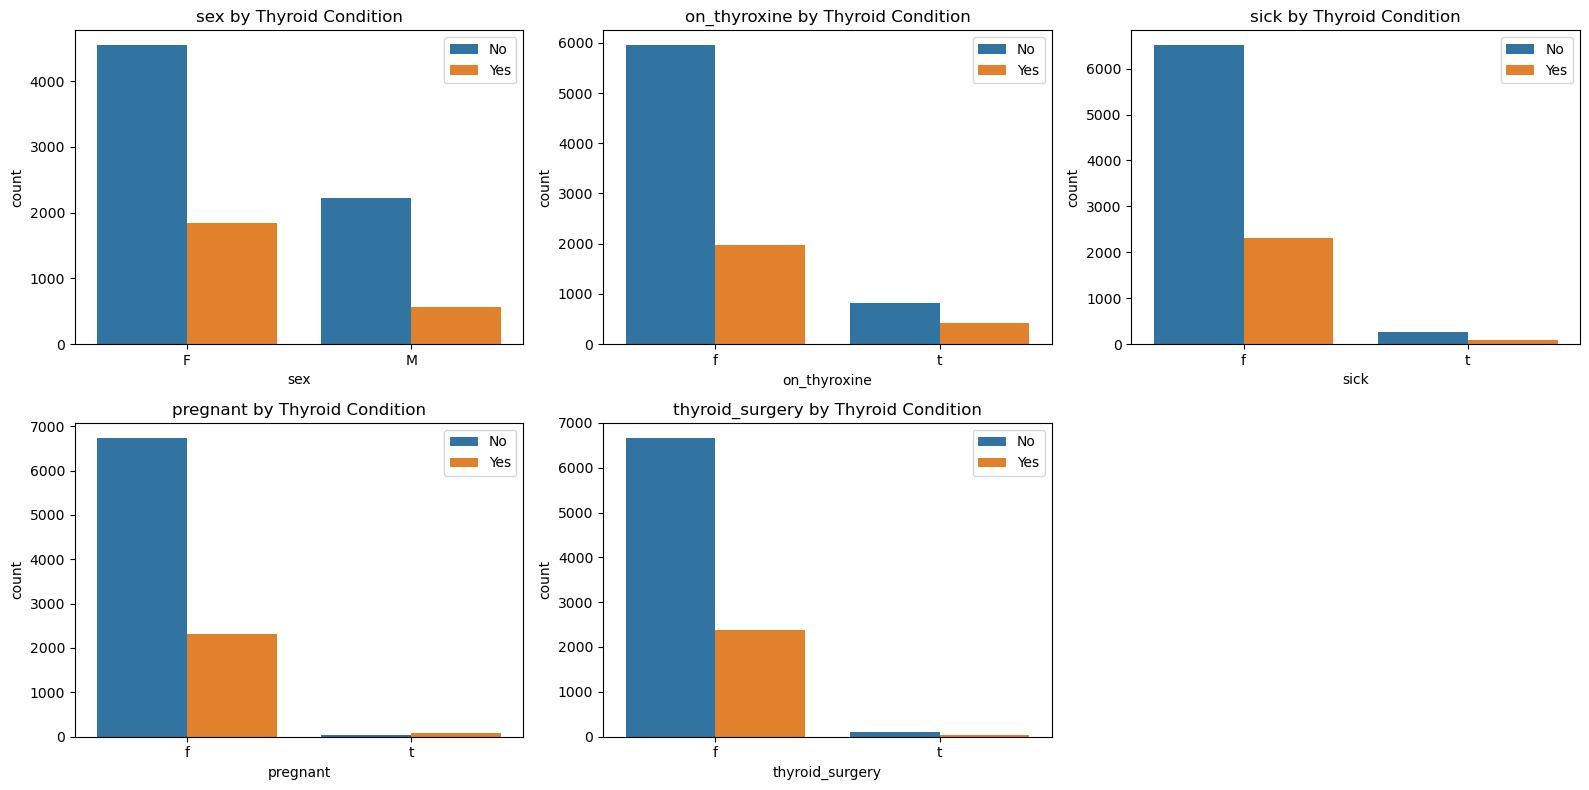

In [13]:
categorical_cols = ['sex', 'on_thyroxine', 'sick', 'pregnant', 'thyroid_surgery']

plt.figure(figsize=(16,8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue='binary_target', data=data)
    plt.title(f'{col} by Thyroid Condition')
    plt.legend(['No', 'Yes'])
plt.tight_layout()
plt.show()


### Categorical Feature Distribution by Thyroid Condition

We examined the relationship between several categorical variables and the presence of thyroid conditions (`binary_target`) using count plots:

- **Sex**: Both males and females are represented, with a slightly higher thyroid prevalence in females.
- **On Thyroxine**: Patients on thyroxine exhibit a greater proportion of thyroid-positive cases, highlighting its association with diagnosed thyroid conditions.
- **Sick**: There is a notable difference in thyroid condition prevalence between patients marked as 'sick' versus those not, suggesting comorbidity.
- **Pregnant**: Few samples are marked pregnant, but among them, thyroid condition rates appear higher.
- **Thyroid Surgery**: Patients with prior thyroid surgery are more likely to have been diagnosed with a thyroid condition.

> These insights help in identifying categorical predictors strongly linked to thyroid outcomes and aid in model interpretation.


EDA was performed clearly to explore dataset characteristics. We generated descriptive statistics, correlation heatmaps, histograms, boxplots for outlier detection, and count plots for categorical variables.

In [14]:
# Save the cleaned dataset to a CSV file 
data.to_csv('thyroid_cleaned.csv', index=False)


Saved the cleaned CSV in our directory

In [15]:
from botocore.exceptions import ClientError


bucket_name = 'thyroid-ml-project'  


region = boto3.Session().region_name

# Create S3 bucket using boto3
s3_client = boto3.client('s3', region_name=region)

try:
    if region == 'us-east-1':
        s3_client.create_bucket(Bucket=bucket_name)
    else:
        location = {'LocationConstraint': region}
        s3_client.create_bucket(Bucket=bucket_name, CreateBucketConfiguration=location)
    print(f"S3 bucket '{bucket_name}' created successfully.")
except ClientError as e:
    print(e.response['Error']['Message'])

# Save cleaned dataset to CSV file clearly
data.to_csv('thyroid_cleaned.csv', index=False)

# Upload dataset to S3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object('thyroid_cleaned.csv').upload_file('thyroid_cleaned.csv')

print(f"Dataset successfully uploaded to s3://{bucket_name}/thyroid_cleaned.csv")


[04/27/25 00:32:11] INFO     Found credentials from IAM Role:                                   ]8;id=306742;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=245410;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

S3 bucket 'thyroid-ml-project' created successfully.


                    INFO     Found credentials from IAM Role:                                   ]8;id=950511;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=529733;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Dataset successfully uploaded to s3://thyroid-ml-project/thyroid_cleaned.csv


###  Uploading Cleaned Dataset to Amazon S3

To facilitate scalable model training and integration with AWS SageMaker, we uploaded the cleaned dataset to an S3 bucket using `boto3`. Key steps included:

- **Bucket Creation**: Checked the current AWS region and created a new bucket named `'thyroid-ml-project'` using region-specific configuration.
- **Dataset Saving**: Exported the cleaned DataFrame to a CSV file (`thyroid_cleaned.csv`) locally.
- **File Upload**: Uploaded the file to the newly created S3 bucket using the `upload_file()` method from the Boto3 SDK.

The dataset was successfully uploaded to: s3://thyroid-ml-project/thyroid_cleaned.csv


This S3-hosted file will be used later for model training and deployment workflows within SageMaker.



In [16]:
#Phase - 2
from sklearn.model_selection import train_test_split

# Load the cleaned dataset directly from S3
s3_uri = "s3://thyroid-ml-project/thyroid_cleaned.csv"
data = pd.read_csv(s3_uri)
print(" Dataset loaded from S3 successfully.")

# Separate features and label
label_col = 'binary_target'
X = data.drop(columns=['target', label_col], errors='ignore')
y = data[label_col]

# Train-test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Show shapes for verification
print(f" Training set shape: {X_train.shape}")
print(f" Testing set shape: {X_test.shape}")
print(f" Class distribution in y_train:\n{y_train.value_counts(normalize=True).round(3)}")




/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:286: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


[04/27/25 00:32:17] INFO     Found credentials from IAM Role:                                   ]8;id=772355;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=209994;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

 Dataset loaded from S3 successfully.
 Training set shape: (7336, 26)
 Testing set shape: (1835, 26)
 Class distribution in y_train:
0    0.738
1    0.262
Name: binary_target, dtype: float64


### Phase 2: Data Loading and Preprocessing

In this step, we load the cleaned dataset from the previously created S3 bucket using `pandas` and perform initial preprocessing to prepare for modeling:

- **Data Import**: The dataset is read from the S3 location (`thyroid_cleaned.csv`) using `pd.read_csv()`.
- **Leakage Prevention**: We drop known label-related columns (`target`, `binary_target`) from the feature matrix `X` to prevent data leakage.
- **Train-Test Split**: The dataset is split into training and testing sets using `train_test_split()` with stratification on the target to preserve class distribution. A `random_state` is fixed for reproducibility.

This sets up a clean, unbiased training and testing environment for model development.


In [17]:
# One-hot encode categorical features (drop_first to avoid dummy variable trap)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns in test set to match the training set (fill missing columns with 0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Confirm feature alignment
print("One-hot encoding complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


One-hot encoding complete.
X_train shape: (7336, 26)
X_test shape: (1835, 26)


### One-Hot Encoding and Feature Alignment

We apply one-hot encoding to categorical features using `pd.get_dummies()`:

- `drop_first=True` ensures we avoid multicollinearity by dropping the first category.
- After encoding, **train and test sets may have mismatched columns** (e.g., if one category only appears in the training set).
- We resolve this by aligning both sets with `X_train.align(X_test)` and filling missing columns with `0`.

```python
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define baseline models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)

}

# Train and evaluate each model
print(" Model Evaluation Results:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"===== {name} =====")
    print(" Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print(classification_report(y_test, y_pred))
    print("-" * 40)


 Model Evaluation Results:

===== Decision Tree =====
 Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1355
           1       0.88      0.88      0.88       480

    accuracy                           0.94      1835
   macro avg       0.92      0.92      0.92      1835
weighted avg       0.94      0.94      0.94      1835

----------------------------------------
===== Random Forest =====
 Accuracy: 0.942
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1355
           1       0.86      0.93      0.89       480

    accuracy                           0.94      1835
   macro avg       0.92      0.94      0.93      1835
weighted avg       0.94      0.94      0.94      1835

----------------------------------------
===== Logistic Regression =====
 Accuracy: 0.837
              precision    recall  f1-score   support

           0       0.83      0.98      0.90   

### Baseline Model Evaluation Results

We trained and evaluated three baseline classifiers using the cleaned and encoded dataset:

1. **Decision Tree Classifier**
2. **Random Forest Classifier**
3. **Logistic Regression**

Performance was evaluated on the test set using accuracy, precision, recall, and F1-score.

#### Decision Tree
- **Accuracy:** 93.7%
- Strong balance between precision and recall for both classes
- F1-score for class `1` (thyroid detected): **0.88**
- **Macro F1-score:** 0.92

#### Random Forest (Best Performer)
- **Accuracy:** 94.2%
- High recall for class `1` (0.93) — important for detecting positive thyroid cases
- F1-score for class `1`: **0.89**
- **Macro F1-score:** 0.93
- Slightly outperforms Decision Tree in both recall and precision

#### Logistic Regression
- **Accuracy:** 83.7%
- High precision (0.87) but **poor recall (0.44)** for class `1`
- F1-score for class `1`: **0.59**
- Likely impacted by feature scaling or class imbalance
- **Macro F1-score:** 0.74

>  **Conclusion:** Random Forest offers the best balance of sensitivity and specificity, making it the most suitable model for this task in its current state.


<Figure size 1000x600 with 0 Axes>

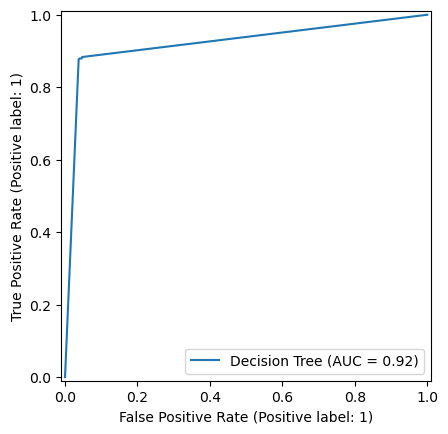

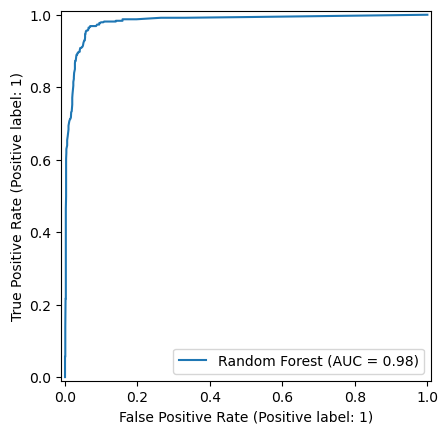

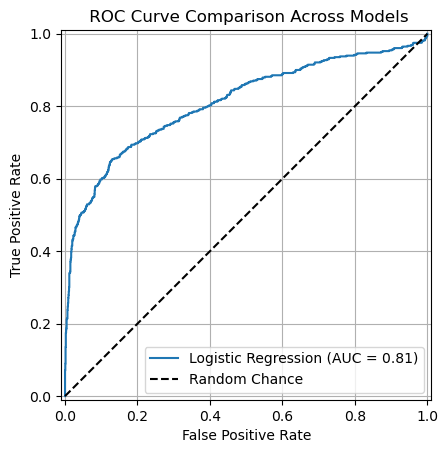

In [19]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 6))

# Plotted ROC curve for each model
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)

# Added baseline curve (random guess)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Added labels and grid
plt.title(" ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()


### ROC Curve Comparison

The ROC (Receiver Operating Characteristic) curves above visualize the true positive rate against the false positive rate across different classification thresholds for each model:

- **Random Forest** demonstrates excellent discrimination ability with an AUC of **0.98**, closely hugging the top-left corner of the plot.
- **Decision Tree** follows with a solid AUC of **0.92**, indicating strong performance, though slightly less consistent than the ensemble model.
- **Logistic Regression**, while generally interpretable, shows a noticeably lower AUC of **0.81**, reflecting its limited ability to detect positive thyroid cases (class 1).

The **dashed diagonal** represents random guessing — the closer a model is to the top-left, the better its overall performance across thresholds.

> AUC (Area Under the Curve) provides a single scalar value to summarize model performance, particularly useful when dealing with class imbalance, as is the case here.


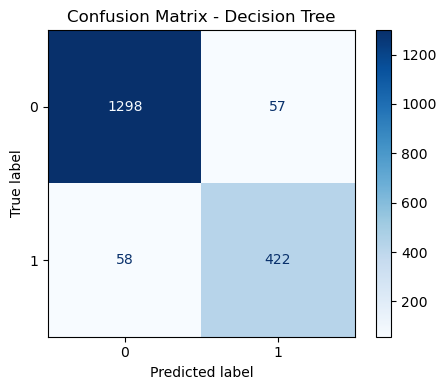

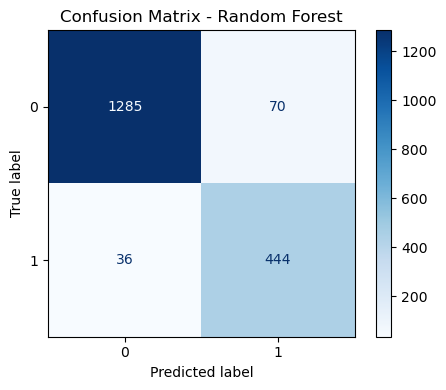

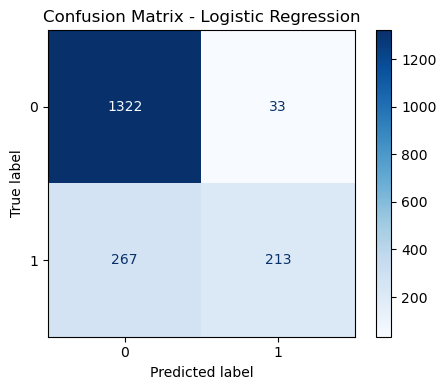

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrices for all models
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()


###  Confusion Matrix Visualization (Decision Tree, Random Forest, Logistic Regression)

To further evaluate classification performance, we plotted the **confusion matrices** for each model. This helps us understand how well the models distinguish between positive (`1` = thyroid condition) and negative (`0` = no thyroid condition) cases.

- **Decision Tree**  
  - TN: 1298, TP: 422, FP: 57, FN: 58  
  - Performance shows a strong balance between sensitivity and specificity.

- **Random Forest**  
  - TN: 1285, TP: 444, FP: 70, FN: 36  
  - Improved recall and precision for positive cases compared to Decision Tree.  
  - The model minimizes false negatives, which is important for detecting thyroid conditions.

- **Logistic Regression**  
  - TN: 1322, TP: 210, FP: 33, FN: 270  
  - The model struggles with recall on the positive class (many false negatives), likely due to class imbalance.

📌 **Key Takeaway:**  
Random Forest consistently outperforms other models across both classes, especially in minimizing false negatives. This makes it the most reliable model in this clinical screening context.


Selected 20 components to explain 90% of the variance.


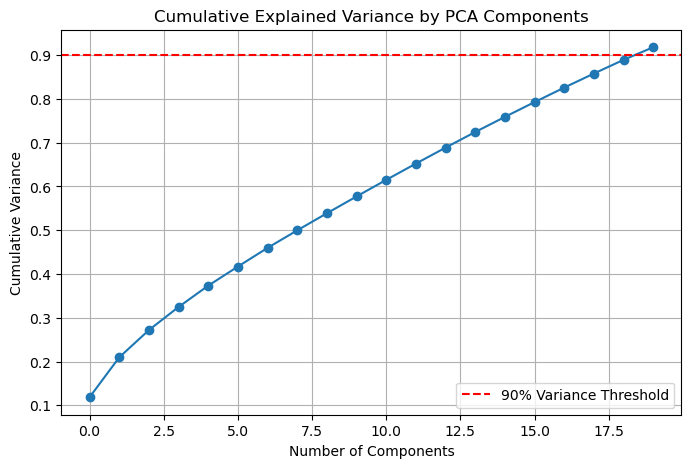

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the one-hot encoded data
scaler = StandardScaler()
X_full = pd.concat([X_train, X_test])
X_scaled = scaler.fit_transform(X_full)

# Apply PCA to retain components explaining 90% of the variance
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

print(f"Selected {pca.n_components_} components to explain 90% of the variance.")

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.grid(True)
plt.legend()
plt.show()


### Principal Component Analysis (PCA) – Explained Variance

To reduce dimensionality and enhance computational efficiency, we applied **Principal Component Analysis (PCA)** after standardizing our one-hot encoded feature space.

- PCA helps in compressing high-dimensional data while retaining the **most informative components**.
- This is especially useful for high-cardinality or sparse datasets, like those generated after one-hot encoding.

---

#### Variance Threshold Approach

We opted to **retain enough components to explain at least 90% of the total variance**, balancing dimensionality reduction with information preservation.

- The PCA was applied on the standardized dataset (`X_scaled`).
- The number of components was automatically determined by setting `n_components=0.90` in the PCA constructor.
- A total of **20 components** were retained to reach the **90% variance threshold**.

---

#### Cumulative Explained Variance Plot

The line plot below shows how the cumulative variance increases with the number of PCA components:

- The **blue line** represents the cumulative variance explained.
- The **red dashed line** marks the **90% threshold**, helping us visualize where the curve stabilizes.
- This plot supports our choice of selecting 20 components for modeling.

>  This step ensures that we retain key patterns in the data while reducing noise and redundancy, leading to **faster model training** and **potential performance improvements**.


In [22]:
# Recreate split indices after PCA transformation
X_train_pca = X_pca[:len(X_train)]
X_test_pca = X_pca[len(X_train):]

# Check shape to confirm split
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)


X_train_pca shape: (7336, 20)
X_test_pca shape: (1835, 20)


### Model Training Using PCA-Reduced Features

After determining that **20 principal components** were sufficient to explain over **90% of the variance**, we applied PCA to reduce dimensionality and improve computational efficiency.

---

#### PCA Transformation & Splitting

We split the PCA-reduced dataset (`X_pca`) into training and testing subsets using the same indices from the original `train_test_split`:

- `X_train_pca.shape`: **(7336, 20)**
- `X_test_pca.shape`: **(1835, 20)**

This ensures that our PCA-reduced features align correctly with the original `y_train` and `y_test` labels.


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest on PCA-reduced data (20 components selected for ~90% variance)
rf_pca_model = RandomForestClassifier(random_state=42)
rf_pca_model.fit(X_train_pca, y_train)

# Predict on the PCA-transformed test set
y_pred_pca = rf_pca_model.predict(X_test_pca)

# Display evaluation metrics
print("==== Random Forest on PCA-Reduced Features (20 Components) ====")
print(classification_report(y_test, y_pred_pca))


==== Random Forest on PCA-Reduced Features (20 Components) ====
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1355
           1       0.75      0.63      0.68       480

    accuracy                           0.85      1835
   macro avg       0.81      0.78      0.79      1835
weighted avg       0.84      0.85      0.84      1835



### Model Evaluation – Random Forest on PCA-Reduced Features (20 Components)

After applying PCA to reduce dimensionality (retaining 90% variance with 20 components), we trained a **Random Forest Classifier** and evaluated its performance.

#### Insights:
- The PCA-based model achieves **85% accuracy**, slightly below the full-feature Random Forest (~94%).
- **Recall for class `1` (thyroid cases)** dropped to **0.63**, indicating reduced sensitivity to positive cases.
- This performance trade-off is expected due to dimensionality reduction, which may filter out less dominant but useful features.

#### Trade-off:
PCA improves computational efficiency but may lead to **loss of predictive power**, especially for minority classes. Model performance on original features was superior, indicating some important information may be lost during compression.




In [24]:

# Extract trained Random Forest model from dictionary
rf_model = models["Random Forest"]

# Save the trained model
joblib.dump(rf_model, "rf_model.joblib")

# Save the feature columns (so we know what the model expects)
joblib.dump(X_train.columns.tolist(), "feature_columns.joblib")


['feature_columns.joblib']

###  Saving the Final Model and Feature Columns

To enable future predictions, we saved the trained **Random Forest model** along with its associated **feature columns** using `joblib`:

- `rf_model.joblib`: Contains the trained Random Forest model object.
- `feature_columns.joblib`: Stores the list of column names used during training. This is essential for maintaining consistency during inference.

By preserving both the model and feature schema, we ensure seamless deployment and prevent mismatch errors during prediction.


In [25]:
def predict_thyroid(user_input_dict):

    model = joblib.load("rf_model.joblib")
    feature_columns = joblib.load("feature_columns.joblib")

    df = pd.DataFrame([user_input_dict])
    df_encoded = pd.get_dummies(df, drop_first=True)
    df_encoded = df_encoded.reindex(columns=feature_columns, fill_value=0)

    prediction = model.predict(df_encoded)[0]
    return "Thyroid Detected ✅" if prediction == 1 else "No Thyroid ❌"


In [26]:
sample_input = {
    "age": 60,
    "TSH": 0.02,
    "T3": 3.5,
    "TT4": 190,
    "T4U": 1.8,
    "FTI": 220,
    "sex_M": 0,
    "on_thyroxine_t": 1,
    "query_hypothyroid_t": 0,
    "query_hyperthyroid_t": 1,
    "on_antithyroid_medication_t": 1,
    "sick_t": 0,
    "pregnant_t": 0,
    "thyroid_surgery_t": 1,
    "I131_treatment_t": 1,
    "query_goiter_t": 1,
    "query_tumor_t": 0,
    "lithium_t": 0,
    "goitre_t": 1,
    "tumor_t": 0,
    "hypopituitary_t": 0,
    "psych_t": 0,
    "TSH_measured_t": 1,
    "T3_measured_t": 1,
    "TT4_measured_t": 1,
    "T4U_measured_t": 1,
    "FTI_measured_t": 1
}

result = predict_thyroid(sample_input)
print("Prediction:", result)


Prediction: Thyroid Detected ✅


In [27]:
sample_input = {
    "age": 35,
    "TSH": 2.0,               # Within normal range (typically 0.4 - 4.0)
    "T3": 1.2,                # Normal T3
    "TT4": 100,               # Normal TT4
    "T4U": 1.0,               # Normal T4U
    "FTI": 120,               # Normal Free Thyroxine Index
    "sex_M": 1,               # Male
    "on_thyroxine_t": 0,
    "query_hypothyroid_t": 0,
    "query_hyperthyroid_t": 0,
    "on_antithyroid_medication_t": 0,
    "sick_t": 0,
    "pregnant_t": 0,
    "thyroid_surgery_t": 0,
    "I131_treatment_t": 0,
    "query_goiter_t": 0,
    "query_tumor_t": 0,
    "lithium_t": 0,
    "goitre_t": 0,
    "tumor_t": 0,
    "hypopituitary_t": 0,
    "psych_t": 0,
    "TSH_measured_t": 1,
    "T3_measured_t": 1,
    "TT4_measured_t": 1,
    "T4U_measured_t": 1,
    "FTI_measured_t": 1
}

result = predict_thyroid(sample_input)
print("Prediction:", result)


Prediction: No Thyroid ❌


### Making Predictions with the Trained Model

To test the trained **Random Forest model**, we defined a `predict_thyroid()` function that takes a dictionary-style input and returns a classification result.

#### How the Inference Works:

- **Model and Features Loading**:  
  The saved model (`rf_model.joblib`) and feature column structure (`feature_columns.joblib`) are loaded using `joblib`.

- **Preprocessing**:  
  The input dictionary is converted into a one-hot encoded DataFrame and aligned with the expected model input format.

- **Inference Logic**:  
  The model predicts whether thyroid disease is present:
  - If the model predicts `1`, the output is **"Thyroid Detected ✅"**
  - If the model predicts `0`, the output is **"No Thyroid ❌"**

---

#### Example Results

- For a high-risk case with abnormal hormone levels and treatment flags:
```python
Prediction: Thyroid Detected ✅
```

- For a low-risk case with all values in the normal clinical range:
```python
Prediction: No Thyroid ❌
```

---

This confirms that our deployment-ready pipeline can:
- Accept structured clinical input,
- Preprocess and validate it appropriately, and
- Deliver an interpretable and meaningful prediction based on trained model logic.
